In [1]:
# pseduo code
import rasterio
import shap
from rasterio.mask import mask
from rasterio.windows import from_bounds
from rasterio.transform import from_bounds 
import numpy as np
import sys
import os
import subprocess
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.utils import register_keras_serializable
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Lambda, Activation
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, Dense, BatchNormalization, Activation, Input, Add
from keras.callbacks import EarlyStopping, ModelCheckpoint
import time
import matplotlib.pyplot as plt
from rasterio.transform import from_bounds
import tensorflow as tf
import numpy as np
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import register_keras_serializable
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError

start_time = time.time()
print("modules established")

## establish file paths
years = list(range(2024, 2025))
Domain = "Sierras"
WorkspaceBase = f"D:/ASOML/{Domain}/"
phv_features = WorkspaceBase + "features/"
tree_workspace = WorkspaceBase + "treeCover/"
modelOuptuts = WorkspaceBase + "modelOutputs/"
final_activation = 'relu'

# this is to get figures for the planning meeting powerpoint
# split up the features and arrarys 

modules established


In [2]:
## function for min-max scaling
def min_max_scale(data, min_val=None, max_val=None, feature_range=(0, 1)):
    """Min-Max normalize a NumPy array to a target range."""
    data = data.astype(np.float32)
    mask = np.isnan(data)

    d_min = np.nanmin(data) if min_val is None else min_val
    d_max = np.nanmax(data) if max_val is None else max_val

    # if d_max == d_min:
    #     raise ValueError("Min and max are equal — can't scale.")
    if d_max == d_min:
        return np.full_like(data, feature_range[0], dtype=np.float32)

    a, b = feature_range
    scaled = (data - d_min) / (d_max - d_min)  # to [0, 1]
    scaled = scaled * (b - a) + a              # to [a, b]

    scaled[mask] = np.nan  # preserve NaNs
    return scaled

In [3]:
def read_aligned_raster(src_path, extent, target_shape, nodata_val=-1):
    height, width = target_shape
    transform = from_bounds(*extent, width=width, height=height)

    with rasterio.open(src_path) as src:
        try:
            data = src.read(
                1,
                out_shape=target_shape,
                resampling=rasterio.enums.Resampling.nearest,
                window=src.window(*extent)
            )
        except Exception as e:
            print(f"Failed to read {src_path}: {e}")
            return np.full(target_shape, nodata_val, dtype=np.float32)

        # Handle nodata in source
        src_nodata = src.nodata
        if src_nodata is not None:
            data = np.where(data == src_nodata, np.nan, data)

        # Replace NaNs or invalid with -1
        data = np.where(np.isnan(data), nodata_val, data)

        return data

In [4]:
## create empty arrays
featureArray = []
targetArray = []

# loop through the years and feature data
for year in years:
    print(f"Processing year {year}")
    targetSplits = WorkspaceBase + f"{year}/SWE_processed_splits/"
    fSCAWorkspace = WorkspaceBase + f"{year}/fSCA/"
    for sample in os.listdir(targetSplits):
        featureTuple = ()
        featureName = []
        # loop through each sample and get the corresponding features
        if sample.endswith("nonull_fnl.tif"):
            # read in data
            with rasterio.open(targetSplits + sample) as samp_src:
                samp_data = samp_src.read(1)
                meta = samp_src.meta.copy()
                samp_extent = samp_src.bounds
                samp_transform = samp_src.transform
                samp_crs = samp_src.crs
    
                # apply a mask to all no data values. Reminder that nodata values is -9999
                mask = samp_data >= 0
                msked_target = np.where(mask, samp_data, -1)
                target_shape = msked_target.shape
    
                # flatted data
                samp_flat = msked_target.flatten()
                

            # try to get the fsca variables 
            sample_root = "_".join(sample.split("_")[:2])
            for fSCA in os.listdir(fSCAWorkspace):
                if fSCA.endswith(".tif") and fSCA.startswith(sample_root):
                    featureName.append(f"{fSCA[:-4]}")
                    fsca_norm = read_aligned_raster(src_path=fSCAWorkspace + fSCA, extent=samp_extent, target_shape=target_shape)
                    # fsca_norm = min_max_scale(fsca_norm, min_val=0, max_val=100)
                    featureTuple += (fsca_norm,)
                    # print(fsca_norm.shape)
                    if fsca_norm.shape != (256, 256):
                        print(f"WRONG SHAPE FOR {sample}: FSCA")
                        output_debug_path = f"./debug_output/{sample_root}_BAD_FSCA.tif"
                        save_array_as_raster(
                            output_path=output_debug_path,
                            array=fsca_norm,
                            extent=samp_extent,
                            crs=samp_crs,
                            nodata_val=-1
                        )
    
            # get a DOY array into a feature 
            date_string = sample.split("_")[1]
            doy_str = date_string[-3:]
            doy = float(doy_str)
            DOY_array = np.full_like(msked_target, doy)
            # doy_norm = min_max_scale(DOY_array,  min_val=0, max_val=366)
            featureTuple += (DOY_array,)
            featureName.append(doy)
    
            # get the vegetation array
            for tree in os.listdir(tree_workspace):
                if tree.endswith(".tif"):
                    if tree.startswith(f"{year}"):
                        featureName.append(f"{tree[:-4]}")
                        tree_norm = read_aligned_raster(
                        src_path=tree_workspace + tree,
                        extent=samp_extent,
                        target_shape=target_shape
                        )
                        # tree_norm = min_max_scale(tree_norm, min_val=0, max_val=100)
                        featureTuple += (tree_norm,)
                        if tree_norm.shape != (256, 256):
                            print(f"WRONG SHAPE FOR {sample}: TREE")
                            output_debug_path = f"./debug_output/{sample_root}_BAD_TREE.tif"
                            save_array_as_raster(
                                output_path=output_debug_path,
                                array=fsca_norm,
                                extent=samp_extent,
                                crs=samp_crs,
                                nodata_val=-1
                            )
            
            # # get all the features in the fodler 
            for phv in os.listdir(phv_features):
                if phv.endswith(".tif"):
                    featureName.append(f"{phv[:-4]}")
                    phv_data = read_aligned_raster(src_path=phv_features + phv, extent=samp_extent, target_shape=target_shape)
                    featureTuple += (phv_data,)
                    if phv_data.shape != (256, 256):
                         print(f"WRONG SHAPE FOR {sample}: {phv}")
                        
            feature_stack = np.dstack(featureTuple)
            if feature_stack.shape[2] != 14:
                print(f"{sample} has shape {feature_stack.shape} — missing or extra feature?")
                print(featureName)
                print(" ")
            else:
                featureArray.append(feature_stack)
                targetArray.append(samp_flat)
    print("You go girl!")
X = np.array(featureArray)
y = np.array(targetArray)
print("all data split into target and feature array")

Processing year 2024
You go girl!
all data split into target and feature array


In [5]:
print(featureName)

['Yuba_2024148_albn83_60m_FSCA', 148.0, '2024_rcmap_NLCD_60_albn83_LTE100', 'ASOML_SNM_aspect_60_albn83', 'ASOML_SNM_curv_60_albn83', 'ASOML_SNM_dem_60_albn83', 'ASOML_SNM_elevSTD_60_albn83', 'ASOML_SNM_GausCurv_60_albn83', 'ASOML_SNM_gradMag_60_albn83', 'ASOML_SNM_lat_60_albn83', 'ASOML_SNM_lon_60_albn83.tif', 'ASOML_SNM_slopeSTD_60_albn83', 'ASOML_SNM_slope_60_albn83', 'ASO_SNM_waterbody_0_1_60_albn83']


In [19]:
def plot_sample(X, y, index, feature_names=None, cmap='GnBu', save_path=None):
    """
    Plots the target SWE raster followed by all feature layers for a given index.
    
    Parameters:
    - X: numpy array of shape (n_samples, height, width, n_features)
    - y: numpy array of shape (n_samples, height*width) or (n_samples, height, width)
    - index: integer, the sample index to visualize
    - feature_names: list of strings for labeling each feature channel
    - cmap: matplotlib colormap for features
    - save_path: str or Path, optional. If provided, saves the figure to this path.
    """
    sample_features = X[index]
    sample_target_flat = y[index]
    sample_target = sample_target_flat.reshape(sample_features.shape[:2])
    
    n_features = sample_features.shape[2]
    total_plots = n_features + 1  # +1 for target
    ncols = 5
    nrows = int(np.ceil(total_plots / ncols))

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*3, nrows*3))
    axes = axes.flatten()

    # Plot the target SWE first
    ax = axes[0]
    im = ax.imshow(sample_target, cmap='Blues')
    ax.set_title("Target SWE", fontsize=10)
    ax.axis('off')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    # Then plot the feature channels
    for i in range(n_features):
        ax = axes[i+1]
        im = ax.imshow(sample_features[:, :, i], cmap=cmap)
        if feature_names and i < len(feature_names):
            ax.set_title(f"{feature_names[i]}", fontsize=9)
        else:
            ax.set_title(f"Feature {i+1}", fontsize=9)
        ax.axis('off')
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    # Hide any unused subplots
    for j in range(total_plots, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✅ Figure saved to: {save_path}")
    
    plt.show()


✅ Figure saved to: D:/ASOML/Sierras/Figures/feature_plot_v2.png


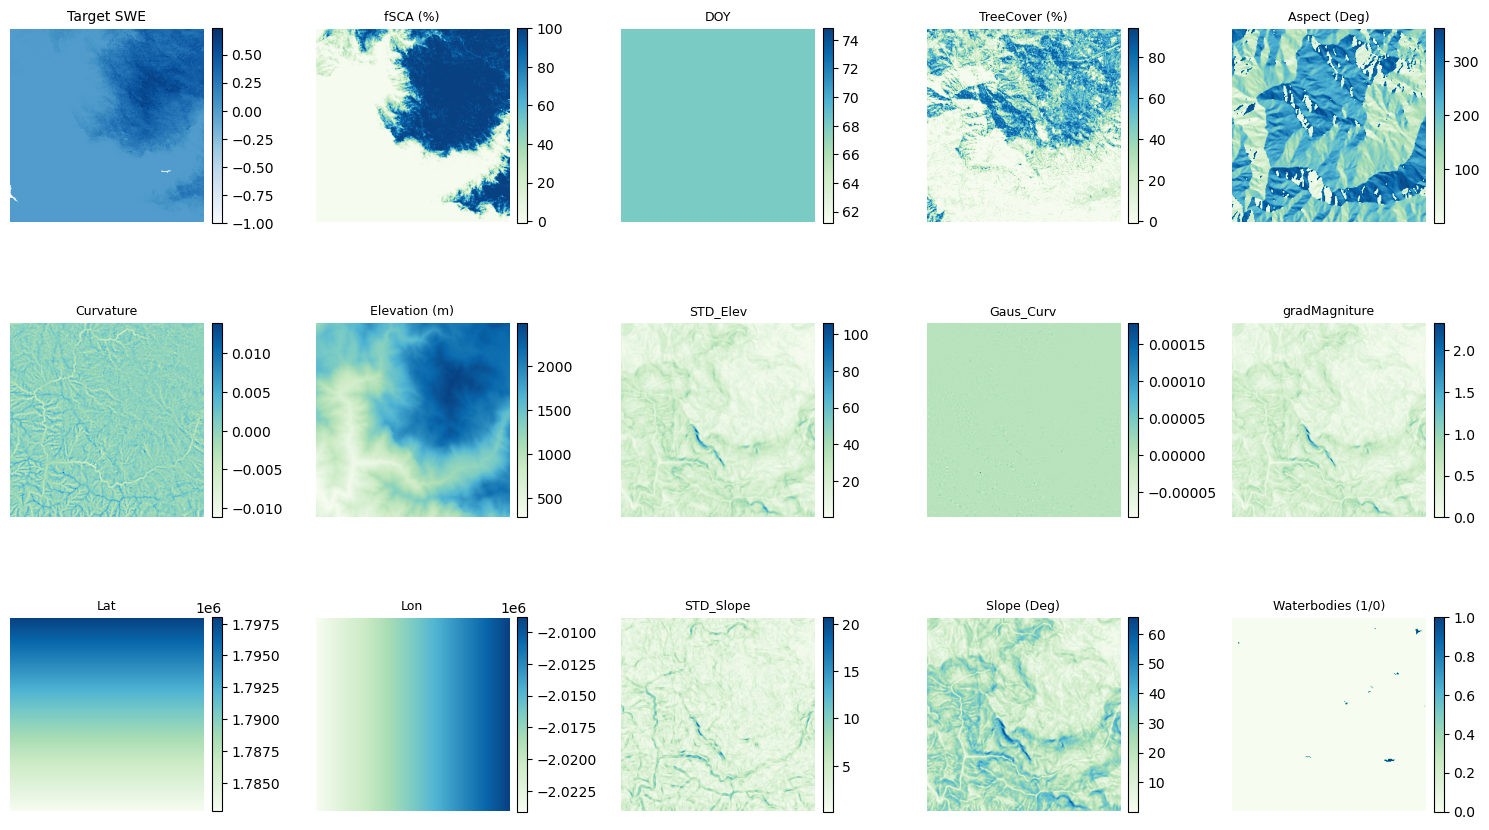

In [33]:
# plot out rasters 
plot_sample(X, y, index=510, feature_names=[
    "fSCA (%)", "DOY", "TreeCover (%)", 
    "Aspect (Deg)", "Curvature", "Elevation (m)", "STD_Elev",
    "Gaus_Curv", "gradMagniture", "Lat", "Lon",
    "STD_Slope", "Slope (Deg)", "Waterbodies (1/0)"
], save_path = fr"D:/ASOML/Sierras/Figures/feature_plot_v2.png")